In [193]:
import os
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pysurfer.freeview_helper as pyview
from itertools import product
from sfp_nsdsyn import utils
from pysurfer.mgz_helper import load_mgzs, map_values_as_mgz

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configurations

In [185]:
nsd_dir ='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset'
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fs_subj_dir='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'
overlay_dir='/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn'
fig_dir='/Volumes/server/Projects/sfp_nsd/derivatives/figures/brain_maps/nsdsyn'

In [62]:
sn_list = [f'subj{sn:02d}' for sn in np.arange(1,9)]

In [166]:
ret_colors = sns.color_palette('Blues_r', as_cmap=True)
ret_colors = np.round(ret_colors(np.linspace(0,1, 8)[::2])[:,0:3]*255).astype(int)
ret_colors = [np.asarray(ret_colors[k, :]) for k in range(3) for _ in range(2)] + [np.asarray(ret_colors[3,:])]

ffas_colors = [np.asarray([255,0,255]), np.asarray([255,0,255])]
ppa_color = [np.asarray([0,0,0])]

label_colors = ret_colors + ffas_colors + ppa_color

labels = ['V1v', 'V1d', 'V2v','V2d', 'V3v','V3d', 'hV4', 'aFFA', 'pFFA', 'PPA']
labels = [f'{roi}.label' for roi in labels]

In [161]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
#mpl.rcParams['figure.dpi'] = 72*2
#mpl.rcParams['savefig.dpi'] = 72*4

# Distributions of precision map values

In [69]:
all_precisions = []
for sn in sn_list:
    precision_lh = load_mgzs(os.path.join(overlay_dir,
                                             f'lh.sub-{sn}_value-precision.mgz'),
                                fdata_only=True, squeeze=True)
    precision_rh = load_mgzs(os.path.join(overlay_dir,
                                             f'rh.sub-{sn}_value-precision.mgz'),
                                fdata_only=True, squeeze=True)
    sn_precision = np.concatenate((precision_lh, precision_rh))
    all_precisions.append(sn_precision)


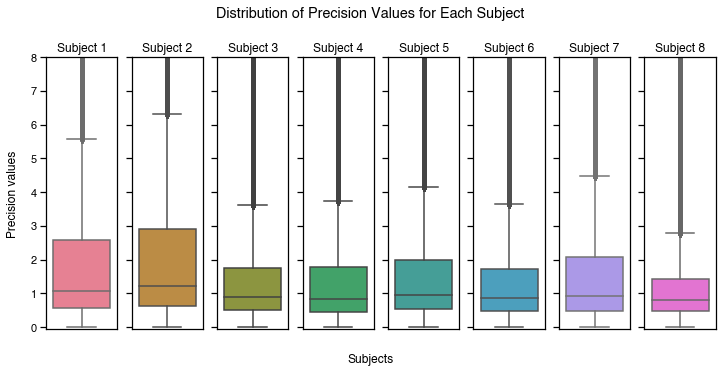

In [184]:
colors = sns.color_palette("husl", n_colors=len(sn_list))
sns.set_context("notebook")
# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(sn_list), figsize=(12, 5), sharey=True)

# Use a for loop to create violin plots for each subject
for i, ax in enumerate(axs):
    sns.boxplot(data=all_precisions[i], color=colors[i], ax=ax)
    ax.set_title('Subject {}'.format(i+1))
    ax.set_ylim(-0.05, 8)
    ax.set_xticks([])
    ax.set_xticklabels([])

# Set common ylabel
fig.text(0.08, 0.5, 'Precision values', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Subjects', ha='center', va='center')
fig.suptitle('Distribution of Precision Values for Each Subject', y=1.02)

# Show the plot
utils.save_fig(os.path.join(fig_dir, 'quantification', 'violinplot_sub-all_value-precision.png'))
plt.show()


# Show individual precision mask

In [167]:
overlay_custom = pyview.make_custom_color_palettes_for_overlay(plt.get_cmap('autumn'),
                                                               val_range=(0,6), n=50)

In [182]:
for sn in sn_list[3:]:
    overlay_file=f'sub-{sn}_value-precision.mgz'
    label_dir=os.path.join(fs_subj_dir, sn, 'label')
    save_path = os.path.join(fig_dir, 'ss', f'ss_sub-{sn}_value-precision.mgz')
    lh_labels, lh_colors = pyview.get_subj_wise_labels('lh', labels, label_colors, label_dir)
    lh_obj = pyview.PyFreeview(fs_subj_dir,
                               sn, 'lh', surf=surf, labels=lh_labels, label_dir=label_dir,
                               overlay=overlay_file, overlay_dir=overlay_dir)

    rh_labels, rh_colors = pyview.get_subj_wise_labels('rh', labels, label_colors, label_dir)
    rh_obj = pyview.PyFreeview(fs_subj_dir,
                               sn, 'rh', surf=surf, labels=rh_labels, label_dir=label_dir,
                               overlay=overlay_file, overlay_dir=overlay_dir,
                               view='inferior', cam_list=[1.25,0,-35,0], save_path=save_path)
    fnl_cm = lh_obj.to_command(
        **{'label_colors': lh_colors,'label_opacity': 1, 'label_outline':  True, 'overlay_custom': overlay_custom}) + ':offset=-60,0,0' + rh_obj.to_command(
        **{'label_colors': rh_colors,'label_opacity': 1, 'label_outline':  True, 'overlay_custom': overlay_custom}).split('freeview')[-1] + ' -viewsize 1024 1024'
    if sn == 'subj01':
        fnl_cm += ' -colorscale'
    os.system(fnl_cm)


# Make mask out of them

In [247]:
threshold=6
for sn, hemi in product(sn_list, ['lh', 'rh']):
    f_path = os.path.join(overlay_dir, f'{hemi}.sub-{sn}_value-precision.mgz')
    precision_mask = load_mgzs(f_path, fdata_only=True, squeeze=False)
    precision_mask[precision_mask < threshold] = 0
    precision_mask[precision_mask > threshold] = 1
    save_path = os.path.join(overlay_dir, f'{hemi}.sub-{sn}_value-precision_masked.mgz')
    map_values_as_mgz(template=f_path, data=precision_mask, save_path=save_path)

In [248]:
threshold=6
for sn, hemi in product(sn_list, ['lh', 'rh']):
    f_path = os.path.join(overlay_dir, f'{hemi}.sub-{sn}_value-precision.mgz')
    precision_mask = load_mgzs(f_path, fdata_only=True, squeeze=False)
    mode_map = load_mgzs(os.path.join(overlay_dir, f'{hemi}.sub-{sn}_value-mode.mgz'), fdata_only=True, squeeze=False)
    precision_mask = np.greater(precision_mask, threshold)
    mode_map[precision_mask == False] = np.nan
    save_path = os.path.join(overlay_dir, f'{hemi}.sub-{sn}_value-mode_masked.mgz')
    map_values_as_mgz(template=f_path, data=mode_map, save_path=save_path)


# Check results

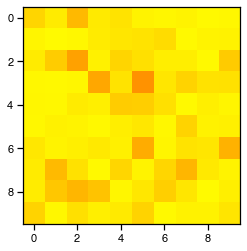

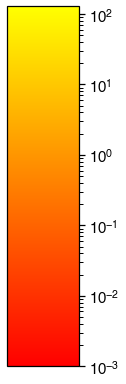

In [242]:

# Sample data
data = np.random.uniform(0.001, 100, size=(10, 10))

# Create a log scale color map
cmap = plt.cm.autumn
norm = mpl.colors.LogNorm(vmin=0.001, vmax=128)

# Plot the data with log scale color map
im = plt.imshow(data, cmap=cmap, norm=norm)

# Create a separate figure for the colorbar
fig_cb = plt.figure(figsize=(1, 5))  # Adjust the figure size as needed
cb_ax = fig_cb.add_axes([0, 0, 1, 1])  # Full height, full width

# Add the colorbar to the separate figure
cb = plt.colorbar(im, cax=cb_ax)
cb.ax.tick_params(axis='y', labelsize=15)
# Save the colorbar as an image
fig_cb.savefig(os.path.join(fig_dir, 'colorbar_image.png'), bbox_inches='tight')

In [243]:
overlay_custom_log = pyview.make_custom_color_palettes_for_overlay(plt.get_cmap('autumn'),
                                                               val_range=(0.01,128), n=6, log_scale=True)

## Ventral view

In [251]:
for sn in sn_list[2:]:
    overlay_file=f'sub-{sn}_value-mode_masked.mgz'
    label_dir=os.path.join(fs_subj_dir, sn, 'label')
    save_path = os.path.join(fig_dir, 'ss', f'ss_sub-{sn}_value-mode_masked.mgz')
    lh_labels, lh_colors = pyview.get_subj_wise_labels('lh', labels, label_colors, label_dir)
    lh_obj = pyview.PyFreeview(fs_subj_dir,
                               sn, 'lh', surf=surf, labels=lh_labels, label_dir=label_dir,
                               overlay=overlay_file, overlay_dir=overlay_dir)

    rh_labels, rh_colors = pyview.get_subj_wise_labels('rh', labels, label_colors, label_dir)
    rh_obj = pyview.PyFreeview(fs_subj_dir,
                               sn, 'rh', surf=surf, labels=rh_labels, label_dir=label_dir,
                               overlay=overlay_file, overlay_dir=overlay_dir,
                               view='inferior', cam_list=[1.25,0,-35,0], save_path=save_path)
    fnl_cm = lh_obj.to_command(
        **{'label_colors': lh_colors,'label_opacity': 1, 'label_outline':  True, 'overlay_custom': overlay_custom_log}) + ':offset=-60,0,0' + rh_obj.to_command(
        **{'label_colors': rh_colors,'label_opacity': 1, 'label_outline':  True, 'overlay_custom': overlay_custom_log}).split('freeview')[-1] + ' -viewsize 1024 1024'
    fnl_cm += ' -colorscale'
    os.system(fnl_cm)

NaN found at voxel (132461, 0, 0, 0)
NaN found at voxel (108378, 0, 0, 0)
NaN found at voxel (84294, 0, 0, 0)
NaN found at voxel (48171, 0, 0, 0)
NaN found at voxel (156543, 0, 0, 0)
NaN found at voxel (228789, 0, 0, 0)
NaN found at voxel (204707, 0, 0, 0)
NaN found at voxel (144502, 0, 0, 0)
NaN found at voxel (60210, 0, 0, 0)
NaN found at voxel (60210, 0, 0, 0)



error: WARNING: 218588 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj03_value-mode_masked.mgz...

error: WARNING: 217427 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj03_value-mode_masked.mgz...



NaN found at voxel (34275, 0, 0, 0)
NaN found at voxel (114250, 0, 0, 0)
NaN found at voxel (171375, 0, 0, 0)
NaN found at voxel (11431, 0, 0, 0)
NaN found at voxel (79975, 0, 0, 0)
NaN found at voxel (91400, 0, 0, 0)
NaN found at voxel (68550, 0, 0, 0)
NaN found at voxel (57125, 0, 0, 0)
NaN found at voxel (159950, 0, 0, 0)
NaN found at voxel (45702, 0, 0, 0)
NaN found at voxel (102825, 0, 0, 0)
NaN found at voxel (22850, 0, 0, 0)
NaN found at voxel (80, 0, 0, 0)
NaN found at voxel (137100, 0, 0, 0)
NaN found at voxel (137100, 0, 0, 0)


error: WARNING: 207141 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj04_value-mode_masked.mgz...

error: WARNING: 204213 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj04_value-mode_masked.mgz...



NaN found at voxel (118560, 0, 0, 0)
NaN found at voxel (148199, 0, 0, 0)
NaN found at voxel (16, 0, 0, 0)
NaN found at voxel (158078, 0, 0, 0)
NaN found at voxel (79040, 0, 0, 0)
NaN found at voxel (187715, 0, 0, 0)
NaN found at voxel (187715, 0, 0, 0)


error: WARNING: 179767 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj05_value-mode_masked.mgz...

error: WARNING: 177288 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj05_value-mode_masked.mgz...



NaN found at voxel (152184, 0, 0, 0)
NaN found at voxel (202910, 0, 0, 0)
NaN found at voxel (2, 0, 0, 0)
NaN found at voxel (2, 0, 0, 0)
, 0)


error: WARNING: 236706 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj06_value-mode_masked.mgz...

error: WARNING: 236593 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj06_value-mode_masked.mgz...



NaN found at voxel (5, 0, 0, 0)
NaN found at voxel (119266, 0, 0, 0)
NaN found at voxel (159018, 0, 0, 0)
NaN found at voxel (159018, 0, 0, 0)


error: WARNING: 177633 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj07_value-mode_masked.mgz...

error: WARNING: 179012 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj07_value-mode_masked.mgz...



NaN found at voxel (0, 0, 0, 0)
NaN found at voxel (179492, 0, 0, 0)
NaN found at voxel (179492, 0, 0, 0)


error: WARNING: 213855 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj08_value-mode_masked.mgz...

error: WARNING: 212577 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj08_value-mode_masked.mgz...



## Posterior view

In [254]:
for sn in sn_list[1:]:
    overlay_file=f'sub-{sn}_value-mode_masked.mgz'
    label_dir=os.path.join(fs_subj_dir, sn, 'label')
    save_path = os.path.join(fig_dir, 'ss', f'ss_sub-{sn}_value-mode_masked_posterior.mgz')
    lh_labels, lh_colors = pyview.get_subj_wise_labels('lh', labels, label_colors, label_dir)
    lh_obj = pyview.PyFreeview(fs_subj_dir,
                               sn, 'lh', surf=surf, labels=lh_labels, label_dir=label_dir,
                               overlay=overlay_file, overlay_dir=overlay_dir)

    rh_labels, rh_colors = pyview.get_subj_wise_labels('rh', labels, label_colors, label_dir)
    rh_obj = pyview.PyFreeview(fs_subj_dir,
                               sn, 'rh', surf=surf, labels=rh_labels, label_dir=label_dir,
                               overlay=overlay_file, overlay_dir=overlay_dir,
                               view='posterior', cam_list=[1.25,0,-25,0], save_path=save_path)
    fnl_cm = lh_obj.to_command(
        **{'label_colors': lh_colors,'label_opacity': 1, 'label_outline':  True, 'overlay_custom': overlay_custom_log}) + ':offset=-60,0,0' + rh_obj.to_command(
        **{'label_colors': rh_colors,'label_opacity': 1, 'label_outline':  True, 'overlay_custom': overlay_custom_log}).split('freeview')[-1] + ' -viewsize 1024 1024'
    fnl_cm += ' -colorscale'

    os.system(fnl_cm)

NaN found at voxel (1, 0, 0, 0)
NaN found at voxel (35946, 0, 0, 0)
NaN found at voxel (95856, 0, 0, 0)
NaN found at voxel (47928, 0, 0, 0)
NaN found at voxel (143784, 0, 0, 0)
NaN found at voxel (191709, 0, 0, 0)
NaN found at voxel (191709, 0, 0, 0)


error: WARNING: 207699 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj02_value-mode_masked.mgz...

error: WARNING: 202129 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj02_value-mode_masked.mgz...



NaN found at voxel (36126, 0, 0, 0)
NaN found at voxel (132461, 0, 0, 0)
NaN found at voxel (96336, 0, 0, 0)
NaN found at voxel (228789, 0, 0, 0)
NaN found at voxel (24084, 0, 0, 0)
NaN found at voxel (192666, 0, 0, 0)
NaN found at voxel (180625, 0, 0, 0)
NaN found at voxel (168584, 0, 0, 0)
NaN found at voxel (12055, 0, 0, 0)
NaN found at voxel (120420, 0, 0, 0)
NaN found at voxel (72252, 0, 0, 0)
NaN found at voxel (48171, 0, 0, 0)
NaN found at voxel (144502, 0, 0, 0)
NaN found at voxel (144502, 0, 0, 0)


error: WARNING: 218588 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj03_value-mode_masked.mgz...

error: WARNING: 217427 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj03_value-mode_masked.mgz...



NaN found at voxel (217071, 0, 0, 0)
NaN found at voxel (80, 0, 0, 0)
NaN found at voxel (182799, 0, 0, 0)
NaN found at voxel (34275, 0, 0, 0)
NaN found at voxel (205647, 0, 0, 0)
NaN found at voxel (194223, 0, 0, 0)
NaN found at voxel (68550, 0, 0, 0)
NaN found at voxel (45702, 0, 0, 0)
NaN found at voxel (125675, 0, 0, 0)
NaN found at voxel (148525, 0, 0, 0)
NaN found at voxel (57125, 0, 0, 0)
NaN found at voxel (114250, 0, 0, 0)
NaN found at voxel (137100, 0, 0, 0)
NaN found at voxel (91400, 0, 0, 0)
NaN found at voxel (102825, 0, 0, 0)
NaN found at voxel (159950, 0, 0, 0)
NaN found at voxel (22850, 0, 0, 0)
NaN found at voxel (11431, 0, 0, 0)
NaN found at voxel (79975, 0, 0, 0)
NaN found at voxel (79975, 0, 0, 0)



error: WARNING: 207141 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj04_value-mode_masked.mgz...

error: WARNING: 204213 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj04_value-mode_masked.mgz...



NaN found at voxel (158078, 0, 0, 0)
NaN found at voxel (29640, 0, 0, 0)
NaN found at voxel (16, 0, 0, 0)
NaN found at voxel (118560, 0, 0, 0)
NaN found at voxel (79040, 0, 0, 0)
NaN found at voxel (39520, 0, 0, 0)
NaN found at voxel (39520, 0, 0, 0)



error: WARNING: 179767 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj05_value-mode_masked.mgz...

error: WARNING: 177288 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj05_value-mode_masked.mgz...



NaN found at voxel (2, 0, 0, 0)
NaN found at voxel (202910, 0, 0, 0)
NaN found at voxel (152184, 0, 0, 0)
NaN found at voxel (152184, 0, 0, 0)


error: WARNING: 236706 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj06_value-mode_masked.mgz...

error: WARNING: 236593 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj06_value-mode_masked.mgz...



NaN found at voxel (5, 0, 0, 0)
NaN found at voxel (29817, 0, 0, 0)
NaN found at voxel (159018, 0, 0, 0)
NaN found at voxel (119266, 0, 0, 0)
NaN found at voxel (39756, 0, 0, 0)
NaN found at voxel (19878, 0, 0, 0)
NaN found at voxel (178894, 0, 0, 0)
NaN found at voxel (79512, 0, 0, 0)
NaN found at voxel (79512, 0, 0, 0)



error: WARNING: 177633 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj07_value-mode_masked.mgz...

error: WARNING: 179012 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj07_value-mode_masked.mgz...



NaN found at voxel (0, 0, 0, 0)
NaN found at voxel (33657, 0, 0, 0)
NaN found at voxel (134620, 0, 0, 0)
NaN found at voxel (89748, 0, 0, 0)
NaN found at voxel (179492, 0, 0, 0)
NaN found at voxel (179492, 0, 0, 0)


error: WARNING: 213855 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.sub-subj08_value-mode_masked.mgz...

error: WARNING: 212577 NaNs found in volume /Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj08_value-mode_masked.mgz...

